# Simple Moving Average

## Imports

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from dateutil.relativedelta import relativedelta

import yfinance as yf
import mplfinance as mpf
import talib

%matplotlib inline

## Загружаем данные

'2024-07-08'

In [53]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2022-01-01'
TEST_START_DATE = '2022-01-01'
TEST_END_DATE = dt.datetime.today().strftime('%Y-%m-%d')

# загружаем данные
df = yf.download('AAPL', start=TRAIN_START_DATE, end=TEST_END_DATE)

[*********************100%%**********************]  1 of 1 completed


In [54]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,3.067143,3.251429,3.041429,3.241071,2.740172,746015200
2009-01-05,3.327500,3.435000,3.311071,3.377857,2.855819,1181608400
2009-01-06,3.426786,3.470357,3.299643,3.322143,2.808715,1289310400
2009-01-07,3.278929,3.303571,3.223571,3.250357,2.748024,753048800
2009-01-08,3.229643,3.326786,3.215714,3.310714,2.799052,673500800


### Посмотрим на данные

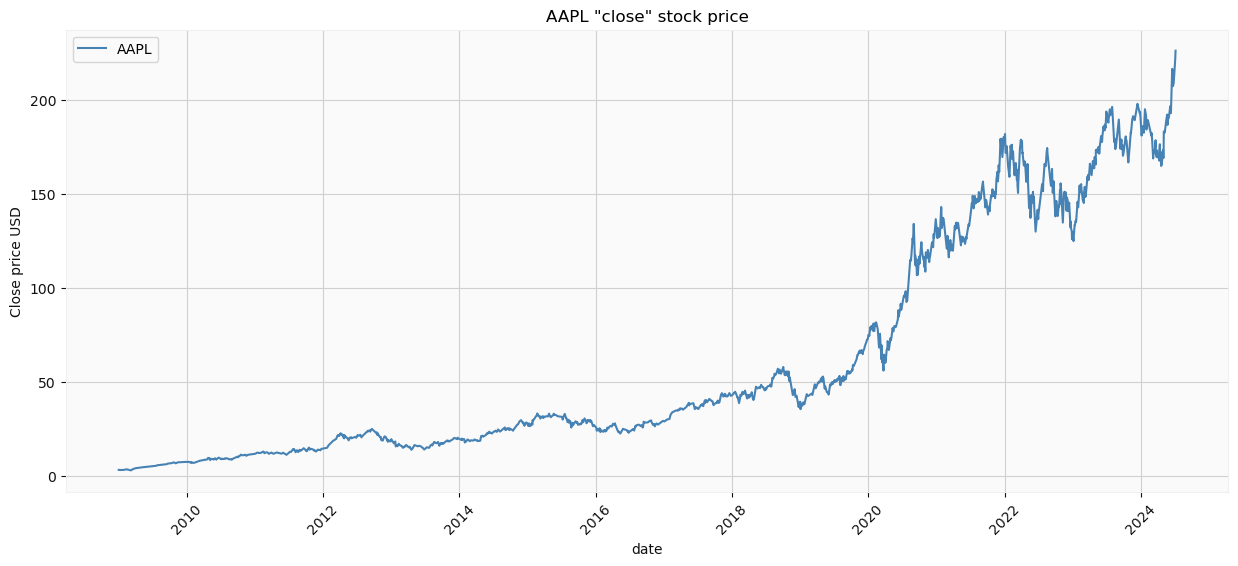

In [56]:
plt.figure(figsize=(15, 6))
plt.plot(df.index, 
        df['Close'], 
        linestyle='-', color='steelblue', label='AAPL')
plt.title('AAPL "close" stock price')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.ylabel('Close price USD')
plt.legend()
plt.show()

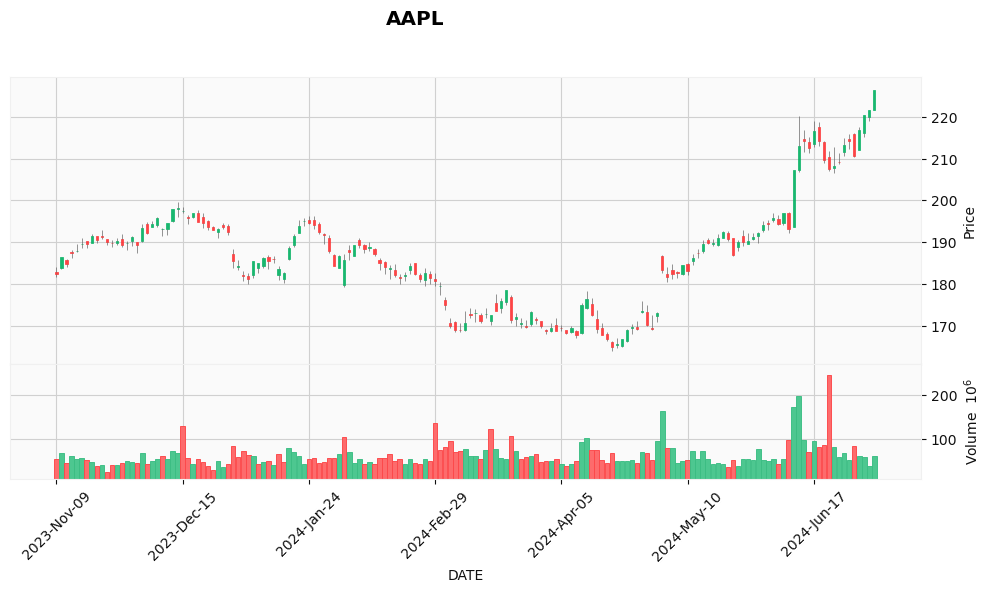

In [60]:
end_day = dt.datetime.today()
start_day = end_day + relativedelta(months=-8)

data = df.loc[(df.index < end_day) & (df.index > start_day)]

mpf.plot(data,
         volume=True,
         style='yahoo',
         type='candle',
         figratio=(22,10),
         title='AAPL',
         ylabel='Price',
        #  savefig='../Presentation/img/volume.png',
         xlabel='DATE')

## Индексы скользящего среднего

In [63]:
df["sma_5"] = talib.SMA(df["Close"], timeperiod=5)
df["sma_10"] = talib.SMA(df["Close"], timeperiod=10)
df["sma_15"] = talib.SMA(df["Close"], timeperiod=15)
df["sma_20"] = talib.SMA(df["Close"], timeperiod=20)
df["sma_50"] = talib.SMA(df["Close"], timeperiod=50)
df["sma_200"] = talib.SMA(df["Close"], timeperiod=200)
df["sma_ratio_5_15"] = df['sma_15'] / df['sma_5']
df["sma_ratio_10_50"] = df['sma_50'] / df['sma_15']
df['sma_5_Volume'] = talib.SMA(df["Volume"], timeperiod=5)
df['sma_10_Volume'] = talib.SMA(df["Volume"], timeperiod=10)
df['sma_15_Volume'] = talib.SMA(df["Volume"], timeperiod=15)
df['sma_50_Volume'] = talib.SMA(df["Volume"], timeperiod=50)
df["sma_Volume_ratio_5_15"] = df['sma_5_Volume'] / df['sma_15_Volume']
df["sma_Volume_ratio_10_50"] = df['sma_10_Volume'] / df['sma_50_Volume']

## Золотое сечение и крест смерти

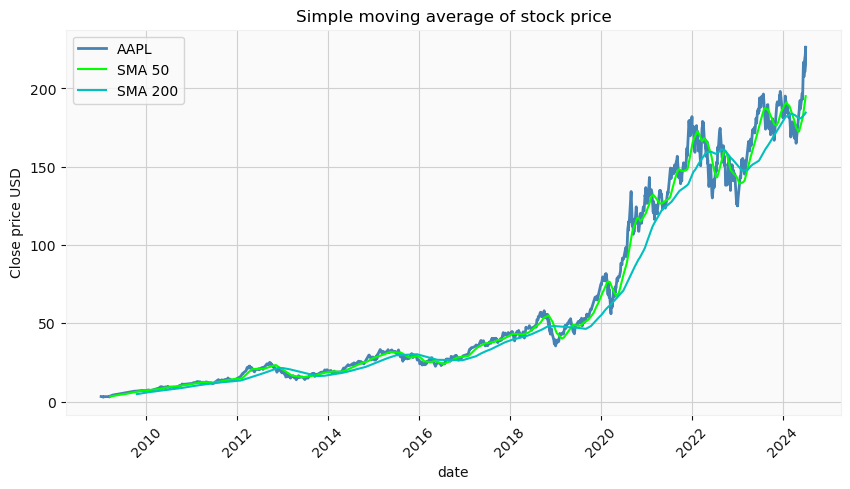

In [64]:

data = df

plt.figure(figsize=(10, 5))
plt.plot(data.index, 
        data['Close'], 
        linestyle='-', linewidth=2, color='steelblue', label='AAPL')
plt.plot(data.index, 
        data['sma_50'], 
        linestyle='-', color='lime', label='SMA 50')
plt.plot(data.index, 
        data['sma_200'], 
        linestyle='-', color='c', label='SMA 200')
plt.title('Simple moving average of stock price')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.ylabel('Close price USD')
plt.legend()
# plt.savefig('img/sma.png')
plt.show()


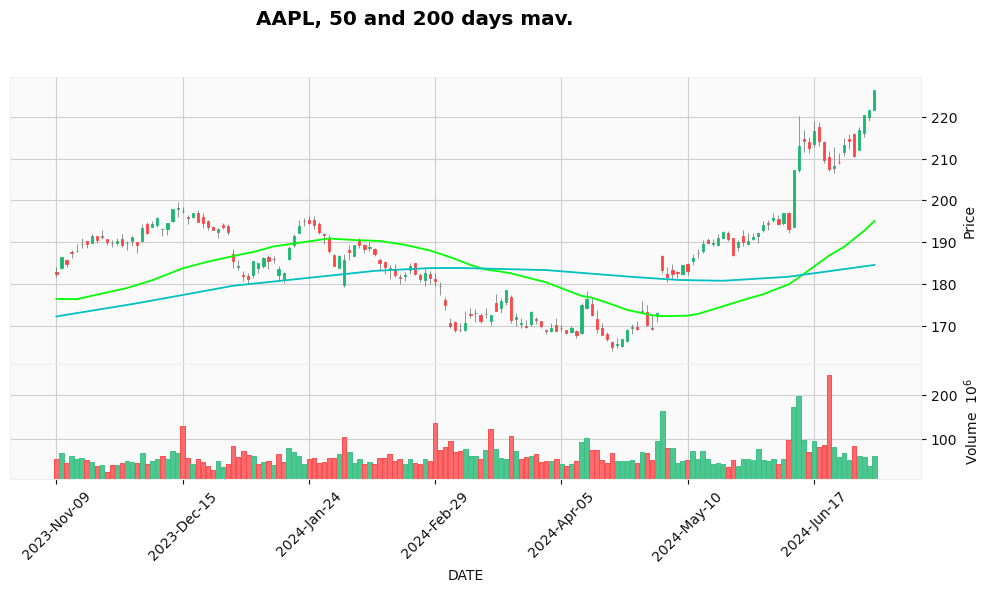

In [65]:
end_day = dt.datetime.today()
start_day = end_day + relativedelta(months=-8)

data = df.loc[(df.index < end_day) & (df.index > start_day)]

apds = [mpf.make_addplot(data['sma_50'], color='lime'),
        mpf.make_addplot(data['sma_200'], color='c')]

fig, axs = mpf.plot(data,
        addplot=apds,
        volume=True,
        style='yahoo',
        type='candle',
        figratio=(22,10),
        title='AAPL, 50 and 200 days mav.',
        ylabel='Price',
        returnfig=True,
        xlabel='DATE')

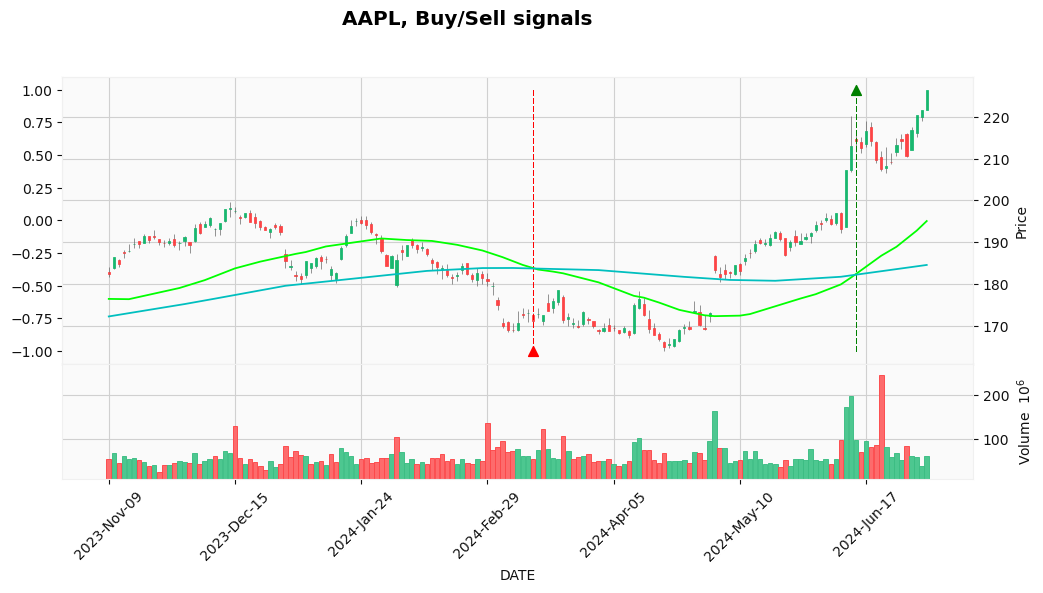

In [66]:
end_day = dt.datetime.today()
start_day = end_day + relativedelta(months=-8)

data = df.loc[(df.index < end_day) & (df.index > start_day)]

# make trade signals
signal = data['sma_50'] > data['sma_200']
diff_plus = signal - signal.shift()
diff_plus[diff_plus<=0] = np.nan
diff_minus = signal - signal.shift()
diff_minus[diff_minus>=0] = np.nan

# make additional plots
apds = [mpf.make_addplot(data['sma_50'],color='lime'),
        mpf.make_addplot(data['sma_200'],color='c'), 
        mpf.make_addplot(diff_plus, type='scatter', markersize=50, marker='^', color='green'),
        mpf.make_addplot(diff_minus, type='scatter', markersize=50, marker='^', color='red'),
]

# color array for trade signals
colors_ar = []
for i in range(len([date_obj.strftime('%Y-%m-%d') for date_obj in diff_plus[~diff_plus.isna()].index.date])):
        colors_ar.append('green')
for i in range(len([date_obj.strftime('%Y-%m-%d') for date_obj in diff_minus[~diff_minus.isna()].index.date])):
        colors_ar.append('red')


# make figure
fig, axs = mpf.plot(data,
	addplot=apds,
	volume=True,
	style='yahoo',
	type='candle',
	figratio=(22,10),
	title='AAPL, Buy/Sell signals',
	ylabel='Price',
	returnfig=True,
	vlines=dict(vlines=[date_obj.strftime('%Y-%m-%d') for date_obj in diff_plus[~diff_plus.isna()].index.date] + [date_obj.strftime('%Y-%m-%d') for date_obj in diff_minus[~diff_minus.isna()].index.date],
				linewidths=(1), 
				colors=colors_ar, 
				linestyle='--'),
	xlabel='DATE')

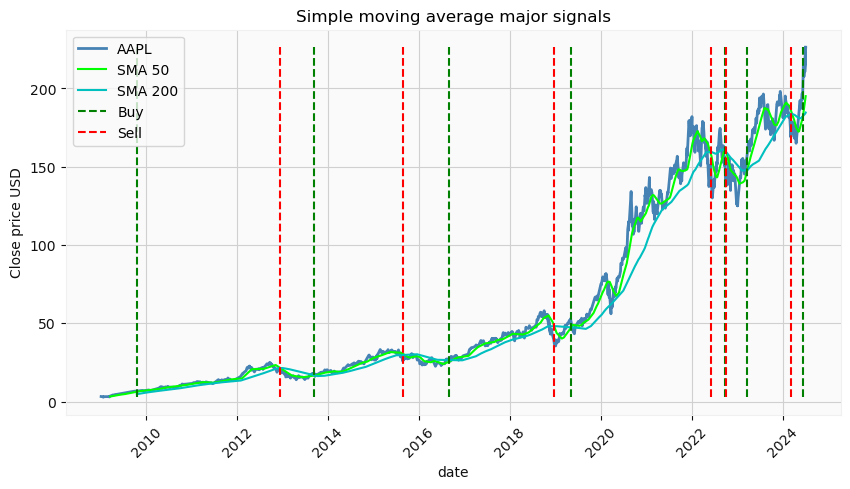

In [67]:
data = df

# make trade signals
signal = data['sma_50'] > data['sma_200']
diff_plus = signal - signal.shift()
diff_plus[diff_plus<=0] = np.nan
diff_minus = signal - signal.shift()
diff_minus[diff_minus>=0] = np.nan

plt.figure(figsize=(10, 5))
plt.plot(data.index, 
        data['Close'], 
        linestyle='-', linewidth=2, color='steelblue', label='AAPL')
plt.plot(data.index, 
        data['sma_50'], 
        linestyle='-', color='lime', label='SMA 50')
plt.plot(data.index, 
        data['sma_200'], 
        linestyle='-', color='c', label='SMA 200')
plt.vlines(x=[date_obj.strftime('%Y-%m-%d') for date_obj in diff_plus[~diff_plus.isna()].index.date],
          ymin=data['Close'].min(),
          ymax=data['Close'].max(),
          colors='green',
          linestyles='--',
          label='Buy')
plt.vlines(x=[date_obj.strftime('%Y-%m-%d') for date_obj in diff_minus[~diff_minus.isna()].index.date],
          ymin=data['Close'].min(),
          ymax=data['Close'].max(),
          colors='red',
          linestyles='--',
          label='Sell')

plt.title('Simple moving average major signals')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.ylabel('Close price USD')
plt.legend()
plt.show()

## Менее значимые торговые сигналы

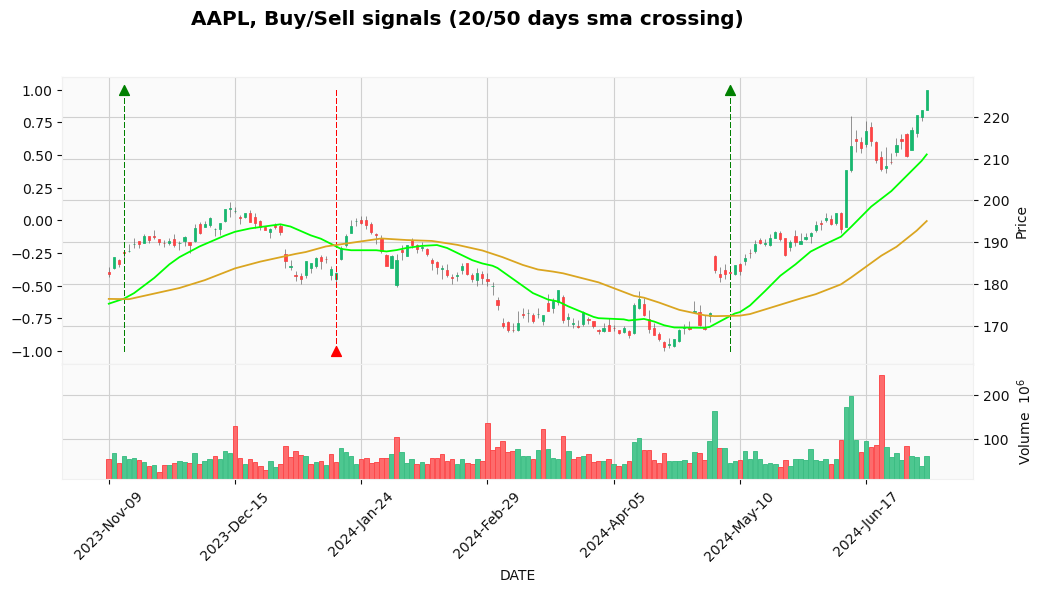

In [68]:
end_day = dt.datetime.today()
start_day = end_day + relativedelta(months=-8)

data = df.loc[(df.index < end_day) & (df.index > start_day)]

# make trade signals
signal = data['sma_20'] > data['sma_50']
diff_plus = signal - signal.shift()
diff_plus[diff_plus<=0] = np.nan
diff_minus = signal - signal.shift()
diff_minus[diff_minus>=0] = np.nan

# make additional plots
apds = [mpf.make_addplot(data['sma_20'],color='lime'),
        mpf.make_addplot(data['sma_50'],color='goldenrod'), 
        mpf.make_addplot(diff_plus, type='scatter', markersize=50, marker='^', color='green'),
        mpf.make_addplot(diff_minus, type='scatter', markersize=50, marker='^', color='red'),
]

# color array for trade signals
colors_ar = []
for i in range(len([date_obj.strftime('%Y-%m-%d') for date_obj in diff_plus[~diff_plus.isna()].index.date])):
        colors_ar.append('green')
for i in range(len([date_obj.strftime('%Y-%m-%d') for date_obj in diff_minus[~diff_minus.isna()].index.date])):
        colors_ar.append('red')


# make figure
fig, axs = mpf.plot(data,
	addplot=apds,
	volume=True,
	style='yahoo',
	type='candle',
	figratio=(22,10),
	title='AAPL, Buy/Sell signals (20/50 days sma crossing)',
	ylabel='Price',
	returnfig=True,
	vlines=dict(vlines=[date_obj.strftime('%Y-%m-%d') for date_obj in diff_plus[~diff_plus.isna()].index.date] + [date_obj.strftime('%Y-%m-%d') for date_obj in diff_minus[~diff_minus.isna()].index.date],
				linewidths=(1), 
				colors=colors_ar, 
				linestyle='--'),
	xlabel='DATE')

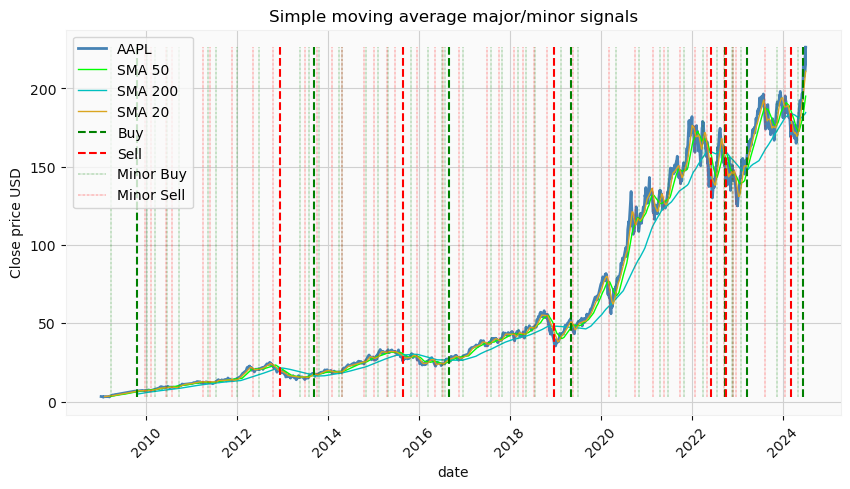

In [87]:
data = df

# make trade signals
signal = data['sma_50'] > data['sma_200']
diff_plus = signal - signal.shift()
diff_plus[diff_plus<=0] = np.nan
diff_minus = signal - signal.shift()
diff_minus[diff_minus>=0] = np.nan

# make trade minor signals
signal_minor = data['sma_20'] > data['sma_50']
diff_plus_minor = signal_minor - signal_minor.shift()
diff_plus_minor[diff_plus_minor <= 0] = np.nan
diff_minus_minor = signal_minor - signal_minor.shift()
diff_minus_minor[diff_minus_minor >= 0] = np.nan

plt.figure(figsize=(10, 5))
plt.plot(data.index, 
        data['Close'], 
        linestyle='-', linewidth=2, color='steelblue', label='AAPL')
plt.plot(data.index, 
        data['sma_50'], 
        linestyle='-', color='lime', linewidth=1, label='SMA 50')
plt.plot(data.index, 
        data['sma_200'], 
        linestyle='-', color='c', linewidth=1, label='SMA 200')
plt.plot(data.index,
        data['sma_20'],
        linestyle='-', color='goldenrod', linewidth=1, label='SMA 20')

plt.vlines(x=[date_obj.strftime('%Y-%m-%d') for date_obj in diff_plus[~diff_plus.isna()].index.date],
          ymin=data['Close'].min(),
          ymax=data['Close'].max(),
          colors='green',
          linestyles='--',
          label='Buy')
plt.vlines(x=[date_obj.strftime('%Y-%m-%d') for date_obj in diff_minus[~diff_minus.isna()].index.date],
          ymin=data['Close'].min(),
          ymax=data['Close'].max(),
          colors='red',
          linestyles='--',
          label='Sell')

plt.vlines(x=[date_obj.strftime('%Y-%m-%d') for date_obj in diff_plus_minor[~diff_plus_minor.isna()].index.date],
          ymin=data['Close'].min(),
          ymax=data['Close'].max(),
          colors='green',
          linestyles='-.',
          linewidth=0.3,
          label='Minor Buy')

plt.vlines(x=[date_obj.strftime('%Y-%m-%d') for date_obj in diff_minus_minor[~diff_minus_minor.isna()].index.date],
          ymin=data['Close'].min(),
          ymax=data['Close'].max(),
          colors='red',
          linestyles='-.',
          linewidth=0.3,
          label='Minor Sell')

plt.title('Simple moving average major/minor signals')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.ylabel('Close price USD')
plt.legend()
plt.show()

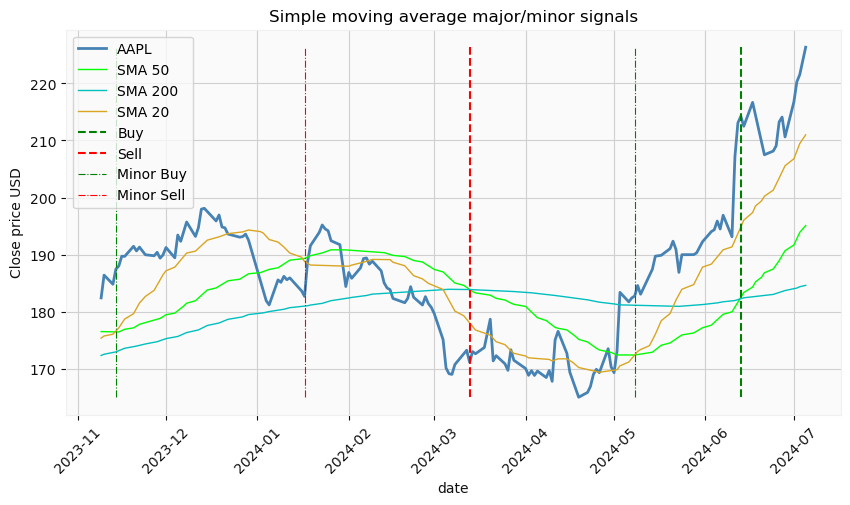

In [76]:
end_day = dt.datetime.today()
start_day = end_day + relativedelta(months=-8)

data = df.loc[(df.index < end_day) & (df.index > start_day)]

# make trade signals
signal = data['sma_50'] > data['sma_200']
diff_plus = signal - signal.shift()
diff_plus[diff_plus<=0] = np.nan
diff_minus = signal - signal.shift()
diff_minus[diff_minus>=0] = np.nan

# make trade minor signals
signal_minor = data['sma_20'] > data['sma_50']
diff_plus_minor = signal_minor - signal_minor.shift()
diff_plus_minor[diff_plus_minor <= 0] = np.nan
diff_minus_minor = signal_minor - signal_minor.shift()
diff_minus_minor[diff_minus_minor >= 0] = np.nan

plt.figure(figsize=(10, 5))
plt.plot(data.index, 
        data['Close'], 
        linestyle='-', linewidth=2, color='steelblue', label='AAPL')
plt.plot(data.index, 
        data['sma_50'], 
        linestyle='-', color='lime', linewidth=1, label='SMA 50')
plt.plot(data.index, 
        data['sma_200'], 
        linestyle='-', color='c', linewidth=1, label='SMA 200')
plt.plot(data.index,
        data['sma_20'],
        linestyle='-', color='goldenrod', linewidth=1, label='SMA 20')

plt.vlines(x=[date_obj.strftime('%Y-%m-%d') for date_obj in diff_plus[~diff_plus.isna()].index.date],
          ymin=data['Close'].min(),
          ymax=data['Close'].max(),
          colors='green',
          linestyles='--',
          label='Buy')
plt.vlines(x=[date_obj.strftime('%Y-%m-%d') for date_obj in diff_minus[~diff_minus.isna()].index.date],
          ymin=data['Close'].min(),
          ymax=data['Close'].max(),
          colors='red',
          linestyles='--',
          label='Sell')

plt.vlines(x=[date_obj.strftime('%Y-%m-%d') for date_obj in diff_plus_minor[~diff_plus_minor.isna()].index.date],
          ymin=data['Close'].min(),
          ymax=data['Close'].max(),
          colors='green',
          linestyles='-.',
          linewidth=0.8,
          label='Minor Buy')

plt.vlines(x=[date_obj.strftime('%Y-%m-%d') for date_obj in diff_minus_minor[~diff_minus_minor.isna()].index.date],
          ymin=data['Close'].min(),
          ymax=data['Close'].max(),
          colors='red',
          linestyles='-.',
          linewidth=0.8,
          label='Minor Sell')

plt.title('Simple moving average major/minor signals')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.ylabel('Close price USD')
plt.legend()
plt.show()

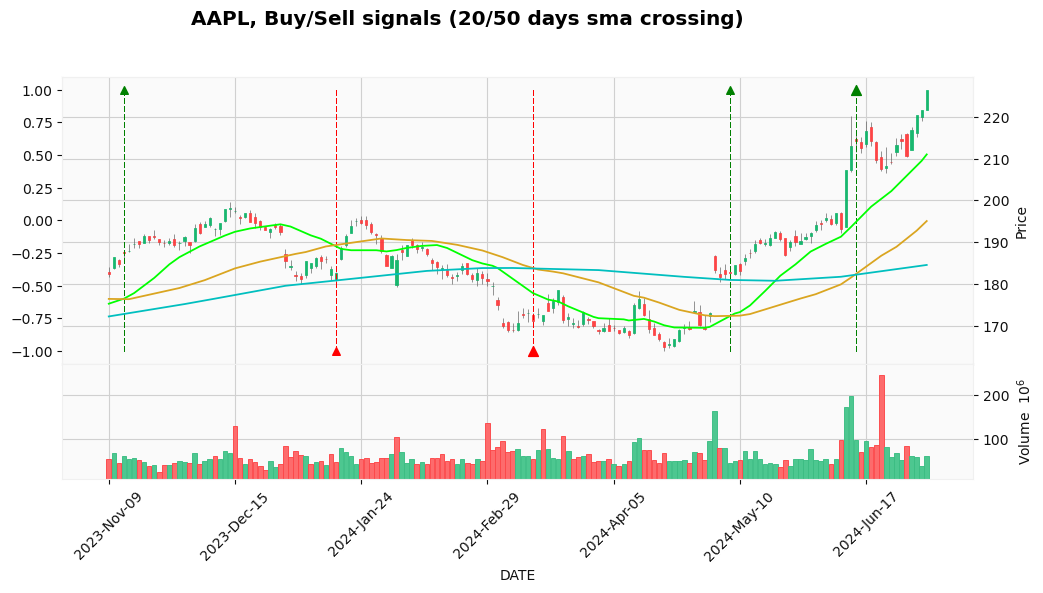

In [86]:
end_day = dt.datetime.today()
start_day = end_day + relativedelta(months=-8)

data = df.loc[(df.index < end_day) & (df.index > start_day)]

# make trade signals
signal = data['sma_50'] > data['sma_200']
diff_plus = signal - signal.shift()
diff_plus[diff_plus<=0] = np.nan
diff_minus = signal - signal.shift()
diff_minus[diff_minus>=0] = np.nan

# make trade minor signals
signal_minor = data['sma_20'] > data['sma_50']
diff_plus_minor = signal_minor - signal_minor.shift()
diff_plus_minor[diff_plus_minor <= 0] = np.nan
diff_minus_minor = signal_minor - signal_minor.shift()
diff_minus_minor[diff_minus_minor >= 0] = np.nan

# make additional plots
apds = [mpf.make_addplot(data['sma_20'],color='lime'),
        mpf.make_addplot(data['sma_50'],color='goldenrod'),
        mpf.make_addplot(data['sma_200'],color='c'),
        mpf.make_addplot(diff_plus, type='scatter', markersize=50, marker='^', color='green'),
        mpf.make_addplot(diff_minus, type='scatter', markersize=50, marker='^', color='red'),
        mpf.make_addplot(diff_plus_minor, type='scatter', markersize=30, marker='^', color='green'),
        mpf.make_addplot(diff_minus_minor, type='scatter', markersize=30, marker='^', color='red'),
]

# color array for trade signals
colors_ar = []
for i in range(len([date_obj.strftime('%Y-%m-%d') for date_obj in diff_plus[~diff_plus.isna()].index.date])):
        colors_ar.append('green')
for i in range(len([date_obj.strftime('%Y-%m-%d') for date_obj in diff_minus[~diff_minus.isna()].index.date])):
        colors_ar.append('red')
for i in range(len([date_obj.strftime('%Y-%m-%d') for date_obj in diff_plus_minor[~diff_plus_minor.isna()].index.date])):
        colors_ar.append('green')
for i in range(len([date_obj.strftime('%Y-%m-%d') for date_obj in diff_minus_minor[~diff_minus_minor.isna()].index.date])):
        colors_ar.append('red')

# make figure
fig, axs = mpf.plot(data,
	addplot=apds,
	volume=True,
	style='yahoo',
	type='candle',
	figratio=(22,10),
	title='AAPL, Buy/Sell signals (20/50 days sma crossing)',
	ylabel='Price',
	returnfig=True,
	vlines=dict(vlines=	[date_obj.strftime('%Y-%m-%d') for date_obj in diff_plus[~diff_plus.isna()].index.date] + 
						[date_obj.strftime('%Y-%m-%d') for date_obj in diff_minus[~diff_minus.isna()].index.date] +
                        [date_obj.strftime('%Y-%m-%d') for date_obj in diff_plus_minor[~diff_plus_minor.isna()].index.date] +
                        [date_obj.strftime('%Y-%m-%d') for date_obj in diff_minus_minor[~diff_minus_minor.isna()].index.date],
				linewidths=(1), 
				colors=colors_ar, 
				linestyle='--'),
	xlabel='DATE')